# minimal code for large spiking network simulation

In [9]:
# import mutable binary heap and fast random number generator  
using DataStructures, RandomNumbers.Xorshifts,StatsBase
import Base.getindex, Base.setindex!

In [10]:
# add getindex and setindex! for mutable binary heap
getindex(d::DataStructures.MutableBinaryHeap,i::Int64) = d.nodes[d.node_map[i]].value
setindex!(d::DataStructures.MutableBinaryHeap,v::Real,i::Int64) = update!(d,i,v)

setindex! (generic function with 126 methods)

In [14]:
# minimal code for spiking network simulation
function spikingnet(n,nspike,k,j0,ratewnt,tau,seedic,seedtopo)
    
    #neuron parameters (leaky integrate and fire neuron)
    iext = tau*sqrt(k)*j0*ratewnt/1000 # iext given by balance equation
    w, c = 1/log(1. + 1/iext),j0/sqrt(k)/(1. + iext) # phase velocity LIF
    phith, phishift = 1., 0.# threshold for LIF
    
    # init. random number generator (Xorshift)
    r = Xoroshiro128Star(seedic) 
    
    #generate heap
    phi = mutable_binary_maxheap(rand(n))
    
    # initialize/preallocate spike raster and vector of receiving neurons
    spikeidx = Int64[] #initialize time
    spiketimes = Float64[] # spike raster
    postidx = Array{Int64,1}(k)
    
    # main loop
    @time for s = 1 : nspike
        
        # find next spiking neuron
        phimax, j = top_with_handle(phi) 
        
        # calculate next spike time
        dphi = phith - phimax - phishift  
        
        # global backshift instead of shifting all phases forward
        phishift += dphi 
        
        # spiking neuron index is seed of rng to reduce memory
        srand(r,j+seedtopo) 
        
        # sample receiving neuron index
        sample!(r,1:n-1,postidx) 
        @inbounds for i = 1:k # avoid selfconnections
          postidx[i] >= j && ( postidx[i]+=1 )
        end
        
        # evaluate phase transition curve
        ptc!(phi,postidx,phishift,w,c) 
        
        # reset spiking neuron
        phi[j]=-phishift  
        
        # store spike raster
        push!(spiketimes,phishift) # store spiketimes
        push!(spikeidx,j) # store spiking neuron
    end
    
    nspike/phishift/n/tau*w, spikeidx, spiketimes*tau/w
end

spikingnet (generic function with 1 method)

In [15]:
#define phase transition curve
function ptc!(phi, postid, phishift, w, c) 
    for i = postid
        phi[i] = - w*log(exp( - (phi[i] + phishift)/w) + c) - phishift
    end
end

ptc! (generic function with 1 method)

In [16]:
#n: # of neurons, k: synapses/neuron, j0: syn. strength, tau: membr. time const.
n,nspike,k,j0,ratewnt,tau,seedic,seedtopo = 10^5,10^5,50,1,1.,.01,1,1

(100000, 100000, 50, 1, 1.0, 0.01, 1, 1)

In [17]:
# compile code
spikingnet(100, 1, 10, j0, ratewnt, tau, seedic, seedtopo) 

  0.000003 seconds (2 allocations: 96 bytes)


(7.050616819048491, [41], [0.00141832])

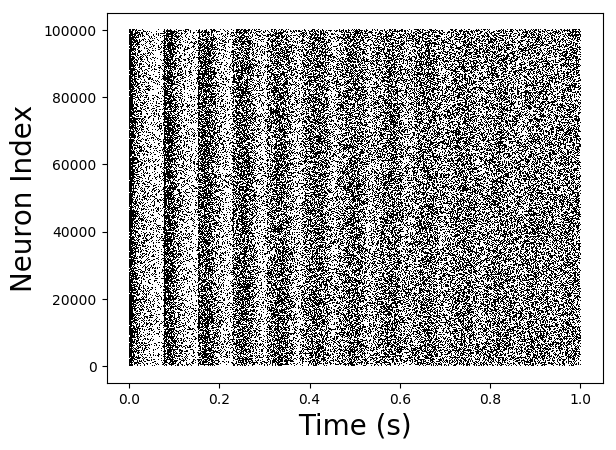

  0.815778 seconds (32 allocations: 4.001 MiB)
rate = 1.0010500902708712


In [18]:
gc()
rate,sidx,stimes = spikingnet(n,nspike,k,j0,ratewnt,tau,seedic,seedtopo)
@show rate
using PyPlot;plot(stimes,sidx,",k",ms=0.1);ylabel("Neuron Index",fontsize=20);xlabel("Time (s)",fontsize=20);